In [2]:
import json, requests
import nltk
import re
from nltk.corpus import sentiwordnet as swn
import time
import timeit
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
import datetime
# import seaborn as sns


In [0]:
def get_reddit_stats(url, num_its):
    '''
    Parameters:
    url (str): Reddit url where we'll scrape data from 
    example: 'http://www.reddit.com/r/cryptocurrency/top.json?sort=top&t=year'
    
    num_its (int): The number of times specified to run the program using the 'after' endpoint
    
    Returns:
    dfs (DataFrame): DataFrame containing post title's, date/time posted, and the number of upvotes
    
    '''
    # delay program a bit to avoid getting blocked by Reddit
    time.sleep(2)
    
    # create lists to hold the post title (text), time in utc format, and the number of upvotes
    text = []
    times = []
    up = []

    # I decided to use the requests package to scrape the data (which is in JSON format)
    r = requests.get(url,  headers={'user-agent': 'Mozilla/5.0'})

    # the title, time, and upvotes can be found in "children", which can be found in "data"
    for post in r.json()['data']['children']:
        text.append(post['data']['title'])
        times.append(post['data']['created_utc'])
        up.append(post['data']['ups'])
        
    num = 0
    
    # there is an "after" attribute in the url which essentially loops to the next page with more posts
    # I put a try/except to break out of the function once the data is null
    while num < num_its:
        try:
            urla = url + '&after=' + r.json()['data']['after']
            r = requests.get(urla, headers={'user-agent': 'Mozilla/5.0'})
            for post in r.json()['data']['children']:
                text.append(post['data']['title'])
                times.append(post['data']['created_utc'])
                up.append(post['data']['ups'])


            num += 1
        except:
            num = num_its
            break
        

    text = np.array(text)
    times = np.array(times)
    up = np.array(up)
    
    dfs = pd.DataFrame({'Sentence' : text, 'Time' : times, 'Up Votes' : up})

    return dfs

In [0]:
txt = get_reddit_stats('http://www.reddit.com/r/cryptocurrency/top.json?sort=top&t=year',10000)


In [4]:
subreddits = ['bitcoin', 'btc', 'ethereum', 'ethtrader', 'Crypto_Currency_News','cryptomarkets']
for sub in subreddits:
    url = 'http://www.reddit.com/r/{}/top.json?sort=top&t=year'.format(sub)
    txt = txt.append(get_reddit_stats(url,10000))
    print(sub)


bitcoin
btc
ethereum
ethtrader
Crypto_Currency_News
cryptomarkets


In [5]:
#Drop posts with the same post titles
txt.drop_duplicates(subset = 'Sentence',keep = 'first', inplace = True)
txt.isnull().sum()

Sentence    0
Time        0
Up Votes    0
dtype: int64

In [6]:
txt.head()

,Sentence,Time,Up Votes
0,The true power of Bitcoin 🔥,1.560846e+09,14636
1,"Ladies and gentlemen, $10,000 = 1 Bitcoin once...",1.561160e+09,9303
2,This is why adoption and the US is so behind w...,1.557319e+09,6810
3,Sarah nailed it.,1.560526e+09,6779
4,Trump: “I am not a fan of Bitcoin and other Cr...,1.562892e+09,6288


In [0]:
# Initialize NLTK's sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()
# create lists to append our sentiment scores too
sen = []
neg = []
neu = []
pos = []
com = []
# Iterate through all the post titles in our DataFrame
for sentence in txt['Sentence']:
    sen.append(sentence)
    neg.append(list(sid.polarity_scores(sentence).values())[0])
    neu.append(list(sid.polarity_scores(sentence).values())[1])
    pos.append(list(sid.polarity_scores(sentence).values())[2])
    com.append(list(sid.polarity_scores(sentence).values())[3])
# convert all the lists to NumPy array's
sen = np.array(sen)
neg = np.array(neg)
neu = np.array(neu)
pos = np.array(pos)
com = np.array(com)
# create a DataFrame with all of our Sentiment Scores
df = pd.DataFrame({'Sentence' : sen, 'Negative' : neg, 'Neutral' : neu, 'Positive' : pos, 'Compound' : com})
df = df.set_index('Sentence')
# Merge our original DataFrame (txt) with our DataFrame containing the sentiment of the post title's
txt = txt.set_index('Sentence')
txt = txt.join(df)

In [10]:
txt = txt.reset_index()
txt

,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound
0,The true power of Bitcoin 🔥,1.560846e+09,14636,0.000,0.588,0.412,0.4215
1,"Ladies and gentlemen, $10,000 = 1 Bitcoin once...",1.561160e+09,9303,0.000,1.000,0.000,0.0000
2,This is why adoption and the US is so behind w...,1.557319e+09,6810,0.115,0.885,0.000,-0.4810
3,Sarah nailed it.,1.560526e+09,6779,0.000,1.000,0.000,0.0000
4,Trump: “I am not a fan of Bitcoin and other Cr...,1.562892e+09,6288,0.072,0.841,0.088,0.1124
...,...,...,...,...,...,...,...
6753,UAE Set for Faster Cryptocurrency Adoption as ...,1.573477e+09,26,0.000,1.000,0.000,0.0000
6754,"Facebook is not politically correct, says Le M...",1.571489e+09,26,0.000,1.000,0.000,0.0000
6755,Band Protocol Staking — An Overview,1.569659e+09,28,0.000,1.000,0.000,0.0000
6756,Tether Pledges $1 Million to Support Hurricane...,1.568223e+09,26,0.192,0.583,0.225,0.1027


In [0]:
txt['Date'] = pd.to_datetime(txt['Time'] , unit = 's').dt.date
txt = txt.sort_values('Date')


# positive = txt[['Time', 'Up Votes', 'Positive']]
# negative = txt[['Time', 'Up Votes', 'Negative']]
# # Remove any columns we don't need
# txt.drop(['Time', 'Up Votes', 'Negative', 'Neutral', 'Positive'], axis = 1, inplace = True)
# txt.reset_index(inplace = True)
# # This DataFrame will be used later on to take our analysis a step further
# post_analysis = txt
# txt = txt.drop('Sentence', axis = 1)
# txt = txt[['Date', 'Compound']]
# #txt = txt.groupby('Date').mean()


In [12]:
txt

,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date
2556,Those Who Say It Cannot Be Done (on-chain scal...,1.556370e+09,141,0.000,0.888,0.112,0.4427,2019-04-27
1655,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,618,0.000,1.000,0.000,0.0000,2019-04-27
5163,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,18,0.000,1.000,0.000,0.0000,2019-04-27
2427,Peter Rizun challenges Adam Back to a debate o...,1.556390e+09,159,0.000,0.778,0.222,0.4588,2019-04-27
3623,Why is the UI/UX of DApps so poor?,1.556404e+09,94,0.363,0.637,0.000,-0.6113,2019-04-27
...,...,...,...,...,...,...,...,...
4729,195! Heaaave boys heaaave,1.587794e+09,84,0.000,1.000,0.000,0.0000,2020-04-25
3060,Got my ETH 2.0 Validator up and running. Now a...,1.587815e+09,328,0.000,1.000,0.000,0.0000,2020-04-25
6408,Clear Regulations Have A Positive Impact On Cr...,1.587822e+09,50,0.000,0.659,0.341,0.7351,2020-04-25
3769,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,95,0.000,1.000,0.000,0.0000,2020-04-25


In [0]:
# txt.to_csv("txt.csv", index=False)

In [5]:
txt = pd.read_csv("txt.csv")
txt

,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date
0,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,615,0.000,1.000,0.000,0.0000,2019-04-27
1,"At a Coinstar in Lubbock, TX.",1.556395e+09,523,0.000,0.553,0.447,0.4995,2019-04-27
2,Bitcoin and Ethereum Trading Coming to E*Trade...,1.556369e+09,331,0.000,1.000,0.000,0.0000,2019-04-27
3,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,19,0.000,1.000,0.000,0.0000,2019-04-27
4,Why is the UI/UX of DApps so poor?,1.556404e+09,94,0.363,0.637,0.000,-0.6113,2019-04-27
...,...,...,...,...,...,...,...,...
7220,Bitcoin Is Confirming Its Safe Haven Status in...,1.587802e+09,103,0.256,0.562,0.181,-0.2960,2020-04-25
7221,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,93,0.000,1.000,0.000,0.0000,2020-04-25
7222,Data shows Ethereum 2.0 is sparking accumulati...,1.587818e+09,155,0.000,1.000,0.000,0.0000,2020-04-25
7223,Winklevoss with the mental gymnastics,1.587818e+09,524,0.000,1.000,0.000,0.0000,2020-04-25


In [6]:
t = txt.Sentence
t

0       "Lightning On the Horizon" would be my title f...
1                           At a Coinstar in Lubbock, TX.
2       Bitcoin and Ethereum Trading Coming to E*Trade...
3       DigiByte - New Cooperation With HoneyPod! - Ma...
4                      Why is the UI/UX of DApps so poor?
                              ...                        
7220    Bitcoin Is Confirming Its Safe Haven Status in...
7221    EIP 1559 (gas burning) Implementation Call Nex...
7222    Data shows Ethereum 2.0 is sparking accumulati...
7223                Winklevoss with the mental gymnastics
7224    I was banned from r/bitcoin for saying people ...
Name: Sentence, Length: 7225, dtype: object

In [7]:
!pip install transformers
from transformers import pipeline

# Allocate a pipeline for sentiment-analysis
nlp = pipeline('sentiment-analysis')

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-finetuned-sst-2-english-modelcard.json' to download model card file.
Creating an empty model card.


In [8]:
import time
sentiments = []

start = time.time()
for i in range(len(t)):
    sentiments.append(nlp(t[i]))
    if i % 100 == 0:
        print(i, time.time() - start)
        start = time.time()

0 0.1885669231414795
100 17.236456871032715
200 16.78525471687317
300 17.081944942474365
400 16.4902446269989
500 17.449058055877686
600 16.61081600189209
700 16.478158950805664
800 17.431878566741943
900 16.9740948677063
1000 16.906460523605347
1100 16.8705313205719
1200 16.854031085968018
1300 17.149903774261475
1400 17.329903841018677
1500 17.05602216720581
1600 16.86495304107666
1700 16.681506633758545
1800 17.248435735702515
1900 16.822462558746338
2000 17.7521870136261
2100 19.693208932876587
2200 17.224892377853394
2300 16.81922221183777
2400 17.216785430908203
2500 17.19593095779419
2600 17.023444652557373
2700 17.134786367416382
2800 16.826509714126587
2900 16.97026777267456
3000 17.222548484802246
3100 17.074102878570557
3200 16.874735116958618
3300 16.884682416915894
3400 16.800885915756226
3500 17.109320640563965
3600 17.042773962020874
3700 16.801472425460815
3800 17.040480136871338
3900 16.869296550750732
4000 17.174849271774292
4100 17.007275104522705
4200 17.09302639961

In [9]:
sen = pd.DataFrame(sentiments, columns = ['sentiment-sentiment_score'])
sen

,sentiment-sentiment_score
0,"{'label': 'NEGATIVE', 'score': 0.92996067}"
1,"{'label': 'NEGATIVE', 'score': 0.9190706}"
2,"{'label': 'NEGATIVE', 'score': 0.95528775}"
3,"{'label': 'POSITIVE', 'score': 0.99871564}"
4,"{'label': 'NEGATIVE', 'score': 0.999817}"
...,...
7220,"{'label': 'POSITIVE', 'score': 0.99135035}"
7221,"{'label': 'NEGATIVE', 'score': 0.9949722}"
7222,"{'label': 'NEGATIVE', 'score': 0.99663895}"
7223,"{'label': 'POSITIVE', 'score': 0.9968879}"


In [10]:
datetime.timedelta(seconds=txt['Time'][0])
from time import gmtime
hour = [gmtime(txt['Time'][i])[3] for  i in range(len(txt))]
hour

[22,
 19,
 12,
 20,
 22,
 16,
 12,
 18,
 13,
 23,
 17,
 15,
 23,
 8,
 6,
 21,
 18,
 16,
 16,
 15,
 19,
 21,
 13,
 8,
 21,
 19,
 15,
 20,
 12,
 12,
 9,
 6,
 23,
 16,
 10,
 15,
 12,
 9,
 15,
 16,
 18,
 4,
 17,
 6,
 12,
 2,
 10,
 15,
 13,
 19,
 14,
 22,
 17,
 1,
 2,
 1,
 17,
 10,
 11,
 13,
 12,
 10,
 1,
 20,
 8,
 19,
 8,
 22,
 17,
 19,
 13,
 6,
 19,
 21,
 7,
 20,
 9,
 1,
 15,
 10,
 16,
 22,
 23,
 4,
 22,
 19,
 11,
 3,
 3,
 22,
 11,
 19,
 9,
 14,
 23,
 20,
 5,
 23,
 9,
 15,
 9,
 14,
 11,
 19,
 15,
 16,
 8,
 19,
 16,
 12,
 19,
 22,
 6,
 22,
 11,
 6,
 18,
 17,
 15,
 11,
 4,
 18,
 10,
 11,
 1,
 7,
 19,
 22,
 23,
 22,
 12,
 19,
 18,
 16,
 17,
 9,
 10,
 20,
 14,
 5,
 13,
 20,
 16,
 15,
 13,
 0,
 13,
 22,
 23,
 12,
 1,
 12,
 3,
 14,
 13,
 3,
 12,
 20,
 21,
 15,
 3,
 11,
 11,
 0,
 12,
 3,
 10,
 1,
 19,
 12,
 23,
 0,
 14,
 10,
 17,
 21,
 9,
 10,
 0,
 1,
 0,
 17,
 2,
 15,
 6,
 12,
 11,
 18,
 2,
 17,
 18,
 17,
 21,
 18,
 14,
 10,
 18,
 19,
 3,
 8,
 10,
 11,
 23,
 12,
 14,
 17,
 16,
 4,
 18,
 18,
 17

In [168]:
a=[]
for i in hour:
    if i//10==0:
        a.append("0"+ str(i))
    else:
        a.append(i)
a

[22,
 19,
 12,
 20,
 22,
 16,
 12,
 18,
 13,
 23,
 17,
 15,
 23,
 '08',
 '06',
 21,
 18,
 16,
 16,
 15,
 19,
 21,
 13,
 '08',
 21,
 19,
 15,
 20,
 12,
 12,
 '09',
 '06',
 23,
 16,
 10,
 15,
 12,
 '09',
 15,
 16,
 18,
 '04',
 17,
 '06',
 12,
 '02',
 10,
 15,
 13,
 19,
 14,
 22,
 17,
 '01',
 '02',
 '01',
 17,
 10,
 11,
 13,
 12,
 10,
 '01',
 20,
 '08',
 19,
 '08',
 22,
 17,
 19,
 13,
 '06',
 19,
 21,
 '07',
 20,
 '09',
 '01',
 15,
 10,
 16,
 22,
 23,
 '04',
 22,
 19,
 11,
 '03',
 '03',
 22,
 11,
 19,
 '09',
 14,
 23,
 20,
 '05',
 23,
 '09',
 15,
 '09',
 14,
 11,
 19,
 15,
 16,
 '08',
 19,
 16,
 12,
 19,
 22,
 '06',
 22,
 11,
 '06',
 18,
 17,
 15,
 11,
 '04',
 18,
 10,
 11,
 '01',
 '07',
 19,
 22,
 23,
 22,
 12,
 19,
 18,
 16,
 17,
 '09',
 10,
 20,
 14,
 '05',
 13,
 20,
 16,
 15,
 13,
 '00',
 13,
 22,
 23,
 12,
 '01',
 12,
 '03',
 14,
 13,
 '03',
 12,
 20,
 21,
 15,
 '03',
 11,
 11,
 '00',
 12,
 '03',
 10,
 '01',
 19,
 12,
 23,
 '00',
 14,
 10,
 17,
 21,
 '09',
 10,
 '00',
 '01',
 '00',
 

In [169]:
hr = pd.DataFrame(a, columns = ['Hour'])
hr

,Hour
0,22
1,19
2,12
3,20
4,22
...,...
7220,08
7221,11
7222,12
7223,12


In [170]:
final_dataframe_txt_sent_hour = pd.concat([txt, sen, hr], axis=1)

In [171]:
final_dataframe_txt_sent_hour.to_csv("final_dataframe_txt_sent_hour", index=False)

In [172]:
final_dataframe_txt_sent_hour

,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date,sentiment-sentiment_score,Hour
0,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,615,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.92996067}",22
1,"At a Coinstar in Lubbock, TX.",1.556395e+09,523,0.000,0.553,0.447,0.4995,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.9190706}",19
2,Bitcoin and Ethereum Trading Coming to E*Trade...,1.556369e+09,331,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.95528775}",12
3,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,19,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'POSITIVE', 'score': 0.99871564}",20
4,Why is the UI/UX of DApps so poor?,1.556404e+09,94,0.363,0.637,0.000,-0.6113,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.999817}",22
...,...,...,...,...,...,...,...,...,...,...
7220,Bitcoin Is Confirming Its Safe Haven Status in...,1.587802e+09,103,0.256,0.562,0.181,-0.2960,2020-04-25,"{'label': 'POSITIVE', 'score': 0.99135035}",08
7221,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,93,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.9949722}",11
7222,Data shows Ethereum 2.0 is sparking accumulati...,1.587818e+09,155,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.99663895}",12
7223,Winklevoss with the mental gymnastics,1.587818e+09,524,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'POSITIVE', 'score': 0.9968879}",12


In [4]:
final_dataframe_txt_sent_hour  = pd.read_csv("final_dataframe_txt_sent_hour")
final_dataframe_txt_sent_hour

,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date,sentiment-sentiment_score,Hour
0,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,615,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.92996067}",22
1,"At a Coinstar in Lubbock, TX.",1.556395e+09,523,0.000,0.553,0.447,0.4995,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.9190706}",19
2,Bitcoin and Ethereum Trading Coming to E*Trade...,1.556369e+09,331,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.95528775}",12
3,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,19,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'POSITIVE', 'score': 0.99871564}",20
4,Why is the UI/UX of DApps so poor?,1.556404e+09,94,0.363,0.637,0.000,-0.6113,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.999817}",22
...,...,...,...,...,...,...,...,...,...,...
7220,Bitcoin Is Confirming Its Safe Haven Status in...,1.587802e+09,103,0.256,0.562,0.181,-0.2960,2020-04-25,"{'label': 'POSITIVE', 'score': 0.99135035}",8
7221,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,93,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.9949722}",11
7222,Data shows Ethereum 2.0 is sparking accumulati...,1.587818e+09,155,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.99663895}",12
7223,Winklevoss with the mental gymnastics,1.587818e+09,524,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'POSITIVE', 'score': 0.9968879}",12


In [110]:
## Btc_data
data = pd.read_csv('Cryptocurrency-correlation-analysis/data/btc_hourly_data.csv')
data

,Time,price,volume,label
0,2020-03-23 03:00:00 UTC,5989.014414,1.233530e+07,5982.209648
1,2020-03-23 04:00:00 UTC,5982.209648,1.469059e+07,5945.645879
2,2020-03-23 05:00:00 UTC,5945.645879,7.071329e+06,5958.296062
3,2020-03-23 06:00:00 UTC,5958.296062,8.727236e+06,5938.628824
4,2020-03-23 07:00:00 UTC,5938.628824,1.074222e+07,5878.498745
...,...,...,...,...
713,2020-04-21 20:00:00 UTC,6904.699602,6.890824e+06,6920.943344
714,2020-04-21 21:00:00 UTC,6920.943344,6.827119e+06,6918.690548
715,2020-04-21 22:00:00 UTC,6918.690548,7.082099e+06,6899.936226
716,2020-04-21 23:00:00 UTC,6899.936226,7.333136e+06,6868.601651


In [111]:
X = data
X

,Time,price,volume,label
0,2020-03-23 03:00:00 UTC,5989.014414,1.233530e+07,5982.209648
1,2020-03-23 04:00:00 UTC,5982.209648,1.469059e+07,5945.645879
2,2020-03-23 05:00:00 UTC,5945.645879,7.071329e+06,5958.296062
3,2020-03-23 06:00:00 UTC,5958.296062,8.727236e+06,5938.628824
4,2020-03-23 07:00:00 UTC,5938.628824,1.074222e+07,5878.498745
...,...,...,...,...
713,2020-04-21 20:00:00 UTC,6904.699602,6.890824e+06,6920.943344
714,2020-04-21 21:00:00 UTC,6920.943344,6.827119e+06,6918.690548
715,2020-04-21 22:00:00 UTC,6918.690548,7.082099e+06,6899.936226
716,2020-04-21 23:00:00 UTC,6899.936226,7.333136e+06,6868.601651


In [114]:
date12 = []
hour1 = []
price1 = []
label1 = []
volume1 = []
for i in range(len(X)):
    date12.append(X.Time[i][:10])
    hour1.append(X.Time[i][11:13])
    price1.append(X.price[i])
    label1.append(X.label[i])
    volume1.append(X.volume[i])
    
dt = pd.DataFrame(date12, columns = ['Date1'])
hr = pd.DataFrame(hour1, columns = ['hour1'])
pr = pd.DataFrame(price1, columns = ['price1'])
lb = pd.DataFrame(label1, columns = ['label1'])
vol = pd.DataFrame(volume1, columns= ['volume1'])
new_data = pd.concat([dt, hr, pr, lb, vol], axis=1)

In [115]:
new_data

,Date1,hour1,price1,label1,volume1
0,2020-03-23,03,5989.014414,5982.209648,1.233530e+07
1,2020-03-23,04,5982.209648,5945.645879,1.469059e+07
2,2020-03-23,05,5945.645879,5958.296062,7.071329e+06
3,2020-03-23,06,5958.296062,5938.628824,8.727236e+06
4,2020-03-23,07,5938.628824,5878.498745,1.074222e+07
...,...,...,...,...,...
713,2020-04-21,20,6904.699602,6920.943344,6.890824e+06
714,2020-04-21,21,6920.943344,6918.690548,6.827119e+06
715,2020-04-21,22,6918.690548,6899.936226,7.082099e+06
716,2020-04-21,23,6899.936226,6868.601651,7.333136e+06


In [27]:
new_data

,Date1,hour1,price1,label1
0,2020-03-23,03,5989.014414,5982.209648
1,2020-03-23,04,5982.209648,5945.645879
2,2020-03-23,05,5945.645879,5958.296062
3,2020-03-23,06,5958.296062,5938.628824
4,2020-03-23,07,5938.628824,5878.498745
...,...,...,...,...
713,2020-04-21,20,6904.699602,6920.943344
714,2020-04-21,21,6920.943344,6918.690548
715,2020-04-21,22,6918.690548,6899.936226
716,2020-04-21,23,6899.936226,6868.601651


In [116]:
new_data.to_csv("new_data1.csv", index=False)

In [117]:
new_data1 = pd.read_csv("new_data1.csv")

In [173]:
final_dataframe_txt_sent_hour


,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date,sentiment-sentiment_score,Hour
0,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,615,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.92996067}",22
1,"At a Coinstar in Lubbock, TX.",1.556395e+09,523,0.000,0.553,0.447,0.4995,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.9190706}",19
2,Bitcoin and Ethereum Trading Coming to E*Trade...,1.556369e+09,331,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.95528775}",12
3,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,19,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'POSITIVE', 'score': 0.99871564}",20
4,Why is the UI/UX of DApps so poor?,1.556404e+09,94,0.363,0.637,0.000,-0.6113,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.999817}",22
...,...,...,...,...,...,...,...,...,...,...
7220,Bitcoin Is Confirming Its Safe Haven Status in...,1.587802e+09,103,0.256,0.562,0.181,-0.2960,2020-04-25,"{'label': 'POSITIVE', 'score': 0.99135035}",08
7221,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,93,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.9949722}",11
7222,Data shows Ethereum 2.0 is sparking accumulati...,1.587818e+09,155,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.99663895}",12
7223,Winklevoss with the mental gymnastics,1.587818e+09,524,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'POSITIVE', 'score': 0.9968879}",12


In [16]:
fi = final_dataframe_txt_sent_hour.loc[(final_dataframe_txt_sent_hour['Date'].isin(new_data['Date1']))] 
fi = fi.reset_index().drop(columns = ['index'])

In [189]:
# X.Time[55][:10]

In [187]:
f2 = fi.drop(columns = ['Time', 'Up Votes', 'Negative', 'Neutral', 'Positive', 'Compound'])

In [192]:
f2.reset_index().drop(columns = ['index']).to_csv("final.csv", index=False)

In [118]:
text_plus_non_text = pd.concat([fi, new_data1], axis=1).dropna()
text_plus_non_text

,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date,sentiment-sentiment_score,Hour,Date1,hour1,price1,label1,volume1
0,A Quick Garbled Circuits Primer -- vbuterin [v...,1.584926e+09,68.0,0.0,1.000,0.000,0.0000,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9994949}",1.0,2020-03-23,3,5989.014414,5982.209648,1.233530e+07
1,"While You’re Under Quarantine, Check These Sit...",1.584926e+09,65.0,0.0,1.000,0.000,0.0000,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9978037}",1.0,2020-03-23,4,5982.209648,5945.645879,1.469059e+07
2,This is why we Bitcoin!,1.584971e+09,209.0,0.0,1.000,0.000,0.0000,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.99105054}",13.0,2020-03-23,5,5945.645879,5958.296062,7.071329e+06
3,Literally me when dogecoin increases in value,1.584940e+09,188.0,0.0,0.714,0.286,0.3400,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.97125334}",4.0,2020-03-23,6,5958.296062,5938.628824,8.727236e+06
4,Bitcoin May Be One of the Last Assets Still Tr...,1.584965e+09,27.0,0.0,0.876,0.124,0.1779,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9984334}",12.0,2020-03-23,7,5938.628824,5878.498745,1.074222e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,🔥Invading Ethereum USDT,1.587567e+09,86.0,0.0,1.000,0.000,0.0000,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.8824061}",14.0,2020-04-14,19,6938.118922,6920.762739,9.895946e+06
545,What Holds Real Decentralization Back,1.587572e+09,8.0,0.0,1.000,0.000,0.0000,2020-04-22,"{'label': 'POSITIVE', 'score': 0.89295495}",16.0,2020-04-14,20,6920.762739,6908.007195,1.137203e+07
546,Russians turn to cash and Bitcoin as coronavir...,1.587562e+09,9.0,0.0,1.000,0.000,0.0000,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.99790883}",13.0,2020-04-14,21,6908.007195,6924.069889,6.563974e+06
547,"Tether Mints $720,000,000 This Month | More Th...",1.587575e+09,36.0,0.0,1.000,0.000,0.0000,2020-04-22,"{'label': 'POSITIVE', 'score': 0.7023987}",17.0,2020-04-14,22,6924.069889,6915.154614,6.009643e+06


In [119]:
text_plus_non_text.to_csv("text_plus_non_text.csv", index = False)

In [135]:
X = text_plus_non_text.drop(columns = ['Time', 'Up Votes', 'Negative', 'Neutral','Positive', 'Compound', 'Date1', 'hour1'])

In [136]:
X

,Sentence,Date,sentiment-sentiment_score,Hour,price1,label1,volume1
0,A Quick Garbled Circuits Primer -- vbuterin [v...,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9994949}",1.0,5989.014414,5982.209648,1.233530e+07
1,"While You’re Under Quarantine, Check These Sit...",2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9978037}",1.0,5982.209648,5945.645879,1.469059e+07
2,This is why we Bitcoin!,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.99105054}",13.0,5945.645879,5958.296062,7.071329e+06
3,Literally me when dogecoin increases in value,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.97125334}",4.0,5958.296062,5938.628824,8.727236e+06
4,Bitcoin May Be One of the Last Assets Still Tr...,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9984334}",12.0,5938.628824,5878.498745,1.074222e+07
...,...,...,...,...,...,...,...
544,🔥Invading Ethereum USDT,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.8824061}",14.0,6938.118922,6920.762739,9.895946e+06
545,What Holds Real Decentralization Back,2020-04-22,"{'label': 'POSITIVE', 'score': 0.89295495}",16.0,6920.762739,6908.007195,1.137203e+07
546,Russians turn to cash and Bitcoin as coronavir...,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.99790883}",13.0,6908.007195,6924.069889,6.563974e+06
547,"Tether Mints $720,000,000 This Month | More Th...",2020-04-22,"{'label': 'POSITIVE', 'score': 0.7023987}",17.0,6924.069889,6915.154614,6.009643e+06


In [137]:
X['sentiment-sentiment_score'][0][31:-1]

'0.9994949'

In [138]:
samples = {}
for i in range(len(X)):  
    temp = X['sentiment-sentiment_score'][i]
    if(temp[11:19] == 'POSITIVE'):
        samples[i] = (1, temp[31:-1])
    else:
        samples[i] = (-1, temp[31:-1])
# print(samples)
data1 = pd.DataFrame.from_dict(samples, orient='index',columns=['Sentiment', 'score'])

In [139]:
data1

,Sentiment,score
0,-1,0.9994949
1,-1,0.9978037
2,-1,0.99105054
3,-1,0.97125334
4,-1,0.9984334
...,...,...
544,-1,0.8824061
545,1,0.89295495
546,-1,0.99790883
547,1,0.7023987


In [140]:
X_new = pd.concat([X, data1], axis=1)
# X_new.to_csv("X_new.csv", index=False)

In [1]:
import pandas as pd
X_new = pd.read_csv("X_new.csv")

In [2]:
# Therefore X1 = data and y1 = label
DATA = X_new.drop(columns = ['sentiment-sentiment_score', 'Sentence'])

y1 = X_new["label1"]

In [3]:
DATA.head()

,Date,Hour,price1,label1,volume1,Sentiment,score
0,2020-03-23,1.0,5989.014414,5982.209648,1.233530e+07,-1,0.999495
1,2020-03-23,1.0,5982.209648,5945.645879,1.469059e+07,-1,0.997804
2,2020-03-23,13.0,5945.645879,5958.296062,7.071329e+06,-1,0.991051
3,2020-03-23,4.0,5958.296062,5938.628824,8.727236e+06,-1,0.971253
4,2020-03-23,12.0,5938.628824,5878.498745,1.074222e+07,-1,0.998433


In [4]:
X1 = DATA.drop(columns = ['Date', 'Hour', 'label1'])
X1.head()

,price1,volume1,Sentiment,score
0,5989.014414,1.233530e+07,-1,0.999495
1,5982.209648,1.469059e+07,-1,0.997804
2,5945.645879,7.071329e+06,-1,0.991051
3,5958.296062,8.727236e+06,-1,0.971253
4,5938.628824,1.074222e+07,-1,0.998433


In [5]:
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\vedan\Anaconda3\envs\ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore
X_train, X_test, y_train, y_test = train_test_split(X1.values, y1.values, shuffle=False, test_size=0.2)

In [7]:
reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

MSE: 2383.705803409989
MAE: 37.761013986728926


In [8]:
# normalizing the data
normalized_data = DATA.drop(columns=['Date', 'Hour', 'Sentiment', 'score', 'label1']).apply(zscore)
X2 = pd.concat([normalized_data, X1['Sentiment'], X1['score']], axis=1)
# y2 = normalized_data['label1']
mean, std = DATA['label1'].mean(), DATA['label1'].std()
# X2 = X2.drop(columns = ['label1'])
X2.head()

,price1,volume1,Sentiment,score
0,-2.190097,-0.250351,-1,0.999495
1,-2.209513,-0.091589,-1,0.997804
2,-2.313844,-0.605176,-1,0.991051
3,-2.277748,-0.493557,-1,0.971253
4,-2.333866,-0.357734,-1,0.998433


In [26]:
# X2.to_csv("reddit_data_normalized.csv", index=False)

In [10]:
Data_new = pd.read_csv("reddit_data_normalized.csv")
Data_new

,price1,volume1,Sentiment,score,Label
0,-2.190097,-0.250351,-1,0.999495,-2.209513
1,-2.209513,-0.091589,-1,0.997804,-2.313844
2,-2.313844,-0.605176,-1,0.991051,-2.277748
3,-2.277748,-0.493557,-1,0.971253,-2.333866
4,-2.333866,-0.357734,-1,0.998433,-2.505441
...,...,...,...,...,...
543,0.590848,-0.526589,1,0.999748,0.518070
544,0.518070,-0.414779,-1,0.882406,0.468546
545,0.468546,-0.315281,1,0.892955,0.432150
546,0.432150,-0.639375,-1,0.997909,0.477983


In [11]:
X3 = Data_new.drop(columns =['Label'])
y3 = Data_new.Label

In [12]:
y3.head()

0   -2.209513
1   -2.313844
2   -2.277748
3   -2.333866
4   -2.505441
Name: Label, dtype: float64

MSE: 0.019581535111418698
MAE: 0.10562625222038163


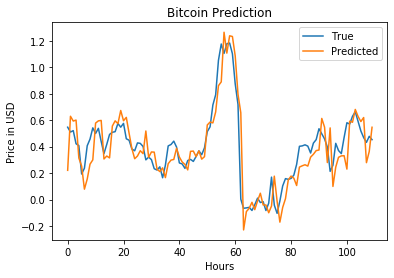

In [13]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)

reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train2, y_train2)
y_pred = reg.predict(X_test2)
print('MSE:', mean_squared_error(y_test2, y_pred))
print('MAE:', mean_absolute_error(y_test2, y_pred))

plt.plot(y_test2, label='True')
plt.plot(y_pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [14]:
y_pred_org = (y_pred * std) + mean
y_test_org = (y_test2 * std) + mean

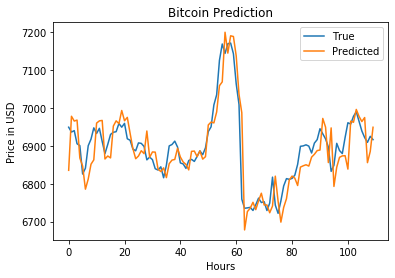

In [15]:
plt.plot(y_test_org, label='True')
plt.plot(y_pred_org, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [16]:
print('MSE:', mean_squared_error(y_test_org, y_pred_org))
print('MAE:', mean_absolute_error(y_test_org, y_pred_org))

MSE: 2388.8444892501284
MAE: 36.89287004971712


In [17]:
# Applying LSTM
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)
X_train3.shape

(438, 4)

In [20]:
X_train3 = X_train3.reshape(X_train3.shape[0], 4 ,1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

model1 = Sequential()
model1.add(LSTM(128, input_shape=(4,1),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(32, activation='tanh'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer="adam", loss="mean_squared_error")

model1.fit(X_train3, y_train3, epochs=50)

# model1.evaluate(X_test3 , y_test3)

Train on 438 samples
Epoch 1/50
438/438 [==============================] - 4s 9ms/sample - loss: 1.0464
Epoch 2/50
438/438 [==============================] - 0s 135us/sample - loss: 0.5824
Epoch 3/50
438/438 [==============================] - 0s 125us/sample - loss: 0.3325
Epoch 4/50
438/438 [==============================] - 0s 130us/sample - loss: 0.2453
Epoch 5/50
438/438 [==============================] - 0s 141us/sample - loss: 0.1961
Epoch 6/50
438/438 [==============================] - 0s 139us/sample - loss: 0.1522
Epoch 7/50
438/438 [==============================] - 0s 132us/sample - loss: 0.1063
Epoch 8/50
438/438 [==============================] - 0s 132us/sample - loss: 0.0819
Epoch 9/50
438/438 [==============================] - 0s 128us/sample - loss: 0.0733
Epoch 10/50
438/438 [==============================] - 0s 132us/sample - loss: 0.0646
Epoch 11/50
438/438 [==============================] - 0s 141us/sample - loss: 0.0621
Epoch 12/50
438/438 [=======================

MSE: 0.021530546724310592
MAE: 0.11080324543663765


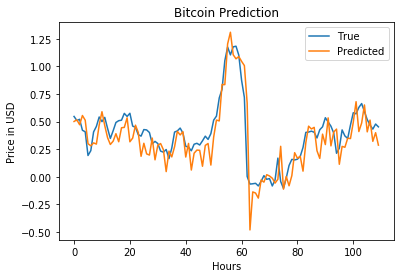

In [21]:
X_test3 = X_test2.reshape(X_test3.shape[0], 4, 1)
y_pred3 = model1.predict(X_test3)
print('MSE:', mean_squared_error(y_test3, y_pred3))
print('MAE:', mean_absolute_error(y_test3, y_pred3))

plt.plot(y_test3, label='True')
plt.plot(y_pred3, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 2626.613255158564
MAE: 38.70106921889521


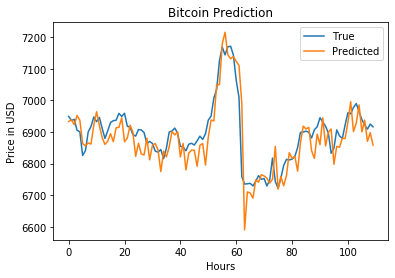

In [22]:
y_pred_org1 = (y_pred3 * std) + mean
y_test_org1 = (y_test3 * std) + mean
print('MSE:', mean_squared_error(y_test_org1, y_pred_org1))
print('MAE:', mean_absolute_error(y_test_org1, y_pred_org1))
plt.plot(y_test_org1, label='True')
plt.plot(y_pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 0.0068995305719053565
MAE: 0.0546571179046694


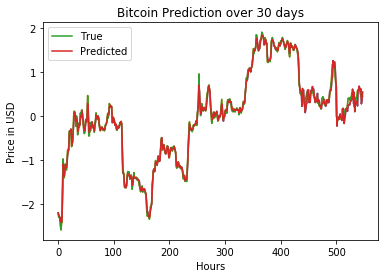

In [24]:
# over the entire 30 days time

pred = reg.predict(X3)
plt.plot(pred)
plt.plot(y3)
print('MSE:', mean_squared_error(y3, pred))
print('MAE:', mean_absolute_error(y3, pred))
plt.plot(y3, label='True')
plt.plot(pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction over 30 days')
plt.legend()

MSE: 841.7065103081572
MAE: 19.09049981193916


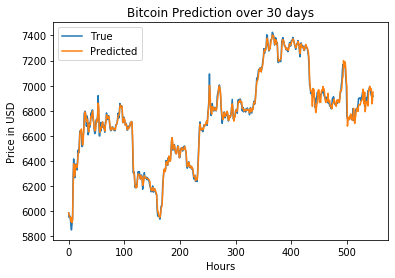

In [25]:
pred_org1 = (pred * std) + mean
y_org1 = (y3 * std) + mean
print('MSE:', mean_squared_error(y_org1, pred_org1))
print('MAE:', mean_absolute_error(y_org1, pred_org1))
plt.plot(y_org1, label='True')
plt.plot(pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction over 30 days')
plt.legend()